Vamos, primeiramente, importar as bibliotecas do Python que serão utilizadas neste projeto:

In [1]:
get_ipython().magic('reset -sf')

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from IPython import get_ipython
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.plotting import plot_decision_regions
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

### Exercício 1 
#### Considere a base de dados sobre doenças cardíacas. 

Leitura dos dados:




In [2]:
random.seed(123)

data = pd.read_csv('heart.csv', header=(0))

data = data.dropna(axis='rows') #remove NaN

# armazena os nomes das classes
classes = np.array(pd.unique(data[data.columns[-1]]), dtype=str)  

nrow, ncol = data.shape
print("Matriz de atributos: Número de linhas:", nrow, " colunas: ", ncol)
attributes = list(data.columns)
data.head(10)

Matriz de atributos: Número de linhas: 303  colunas:  14


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


Vamos construir as variáveis $X$ e $y$, sendo que o processo classificação se resume em estimar a função $f$ na relação $y = f(X) + \epsilon$, onde $\epsilon$ é o erro, que tem distribuição normal com média igual a zero e variância $\sigma^2$.

Vamos converter os dados para o formato Numpy para facilitar a manipulação.

In [3]:
data = data.to_numpy()
nrow,ncol = data.shape
y = data[:,-1]
X = data[:,0:ncol-1]

Vamos normalizar os dados, de modo a evitar o efeito da escala dos atributos.

In [4]:
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

In [6]:
print('Dados transformados:')
print('Media: ', np.mean(X, axis = 0))
print('Desvio Padrao:', np.std(X, axis = 0))

Dados transformados:
Media:  [ 4.69005106e-17 -1.40701532e-16  2.34502553e-17 -7.03507659e-16
 -1.11388713e-16 -2.34502553e-17  1.46564096e-16 -6.80057404e-16
 -4.69005106e-17  2.34502553e-17 -1.40701532e-16 -2.34502553e-17
 -1.64151787e-16]
Desvio Padrao: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Para treinar o classificador, vamos definir o conjunto de teste e treinamento.

In [8]:
p = 0.8 # fracao de elementos no conjunto de treinamento
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = p, random_state = 42)

#### Faça o pré-processamento dos dados e classifique os pacientes de acordo com a variável “target”. Considere os classificadores: Bayesiano paramétrico, Bayesiano não-paramétrico e Naive Bayes.

#### - Classificador Bayesiano paramétrico

Neste caso, estamos assumindo que cada variável está distribuída de acordo com uma distribuição Normal.

Já selecionamos os conjuntos de treinamento e teste anteriormente. 
No conjunto de treinamento, vamos calcular a média e desvio padrão de cada atributo para cada classe. 

A seguir, realizamos a classificação dos dados usando a teoria da decisão Bayesiana, isto é:  𝑋∈𝐶𝑖  se, e somente se,  𝑃(𝐶𝑖|𝑋)=max𝑃(𝐶𝑗|𝑋)  para todo  𝑗 .


In [9]:
#matriz para armazenar as probabilidades
P = pd.DataFrame(data=np.zeros((x_test.shape[0], len(classes))), columns = classes) 

Pc = np.zeros(len(classes)) #fração de elementos em cada classe

for i in np.arange(0, len(classes)):
    elements = tuple(np.where(y_train == int(classes[i])))
    Pc[i] = len(elements)/len(y_train)
    Z = x_train[elements,:][0]
    m = np.mean(Z, axis=0)
    cv = np.cov(np.transpose(Z))
    for j in np.arange(0,x_test.shape[0]):
        x = x_test[j,:]
        pj = multivariate_normal.pdf(x, mean=m, cov=cv, allow_singular=True)
        P[classes[i]][j] = pj*Pc[i]

In [10]:
print(P)

               1             0
0   2.001109e-14  1.511054e-10
1   1.174376e-12  5.348235e-12
2   1.275411e-11  1.068613e-12
3   1.509065e-14  5.265177e-12
4   1.036353e-11  1.175595e-14
..           ...           ...
56  3.377823e-12  3.851522e-10
57  3.093257e-08  1.651703e-09
58  3.587985e-16  6.785043e-13
59  2.394387e-14  5.801795e-09
60  6.545471e-14  4.830762e-10

[61 rows x 2 columns]


O resultado acima nos mostra a probabilidade de a variável resposta ser 0 ou 1, a predição será feita em relação ao mais provável para cada observação.

In [11]:
y_pred = []
for i in np.arange(0, x_test.shape[0]):
    c = np.argmax(np.array(P.iloc[[i]]))
    y_pred.append(classes[c])
y_pred = np.array(y_pred, dtype=int)
print(y_pred)

[0 0 1 0 1 1 1 0 0 1 1 0 1 0 1 1 1 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 0 1 0 0
 1 1 1 1 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0]


In [12]:
score = accuracy_score(y_pred, y_test)
print('Accuracy:', score)

Accuracy: 0.8360655737704918


A acurácia do modelo de previsão é de 83,60%, o que significa que o modelo está acertando 83,60% dos resultados previstos em relação ao conjunto de teste.
#### - Classificador Bayesiano não-paramétrico

Para o caso unidimensional, seja $(X_1,X_2, \ldots, X_n)$ uma amostra aleatória unidimensional identicamente distribuída de acordo com alguma função de distribuição $f$ não conhecida. Para estimarmos o formato de $f$, usamos um estimador (kernel density estimator):$$
\widehat{f}_{h}(x)={\frac {1}{n}}\sum _{i=1}^{n}K_{h}(x-x_{i})={\frac {1}{nh}}\sum _{i=1}^{n}K{\Big (}{\frac {x-x_{i}}{h}}{\Big )},
$$onde $K$ é a função kernel. A estimação depende do parâmetro $h$, que é um parâmetro livre e controla a abertura da função.

Vamos utilizar o método Kernel Density Estimation para realizar a classificação:

In [13]:
random.seed(123)
data = pd.read_csv('heart.csv', header=(0))

classes = np.array(pd.unique(data[data.columns[-1]]), dtype=int)  

# Converte para matriz e vetor do numpy
data = data.to_numpy()
nrow,ncol = data.shape
y = data[:,-1]
X = data[:,0:ncol-1]

# Transforma os dados para terem media igual a zero e variancia igual a 1
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

# Seleciona os conjuntos de treinamento e teste
p = 0.8 # fraction of elements in the training set
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = p, random_state = 42)

# Matriz que armazena as probabilidades para cada classe
P = pd.DataFrame(data=np.zeros((x_test.shape[0], len(classes))), columns = classes) 
Pc = np.zeros(len(classes)) # Armazena a fracao de elementos em cada classe
h = 2
for i in np.arange(0, len(classes)): # Para cada classe
    elements = tuple(np.where(y_train == classes[i])) # Elementos na classe i
    Pc[i] = len(elements)/len(y_train) # Probabilidade pertencer a classe i
    Z = x_train[elements,:][0] # Elementos no conjunto de treinamento
    kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(Z)
    for j in np.arange(0,x_test.shape[0]): # Para cada observacao no conjunto de teste
        x = x_test[j,:]
        x = x.reshape((1,len(x)))
        # Calcula a probabilidade pertencer a cada classe
        pj = np.exp(kde.score_samples(x)) 
        P[classes[i]][j] = pj*Pc[i]
        
y_pred = [] # Vetor com as classes preditas
for i in np.arange(0, x_test.shape[0]):
    c = np.argmax(np.array(P.iloc[[i]]))
    y_pred.append(classes[c])
y_pred = np.array(y_pred, dtype=int)

# Calcula a acuracia
score = accuracy_score(y_pred, y_test)
print('Acuracia:', score)

Acuracia: 0.8852459016393442


A acurácia do modelo de previsão é de 88,52%, o que significa que o modelo está acertando 88,52% dos resultados previstos em relação ao conjunto de teste, e consideramos que essa é uma boa acurácia.

#### - Classificador Naive Bayes

Neste classificador, podemos assumir que os atributos são normalmente distribuídos.

In [14]:
#data = pd.read_csv('data/vertebralcolumn-3C.csv', header=(0))
data = pd.read_csv('heart.csv', header=(0))

data = data.dropna(axis='rows') #remove NaN
# armazena os nomes das classes
classes = np.array(pd.unique(data[data.columns[-1]]), dtype=str)  

print("Número de linhas e colunas na matriz de atributos:", data.shape)
attributes = list(data.columns)
data.head(10)

data = data.to_numpy()
nrow,ncol = data.shape
y = data[:,-1]
X = data[:,0:ncol-1]

Número de linhas e colunas na matriz de atributos: (303, 14)


A seguir, vamos selecionar os conjuntos de treinamento e teste.


In [15]:
from sklearn.model_selection import train_test_split
p = 0.7 # fracao de elementos no conjunto de treinamento
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = p, random_state = 42)

Inicialmente, definimos uma função para calcular a densidade de probabilidade conjunta:$$p(\vec{x}|C_i) = \prod_{j=1}^d p(x_j|C_i), \quad i=1,\ldots, k$$onde $C_i$ são as classes. 

Se a distribuição for normal, temos que cada atributo $X_j$ tem a seguinte função densidade de probabilidade associada, para cada classe:$$
p(x_j|C_i) = \frac{1}{\sqrt{2\pi\sigma_{C_i}}}\exp \left[ -\frac{1}{2}\left( \frac{x_j-\mu_{C_i}}{\sigma_{C_i}}\right)^2 \right], \quad i=1,2,\ldots, k.
$$Assim, definimos uma função para calcular a função de verossimilhança.

In [16]:
def likelyhood(y, Z):
    def gaussian(x, mu, sig):
        return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
    prob = 1
    for j in np.arange(0, Z.shape[1]):
        m = np.mean(Z[:,j])
        s = np.std(Z[:,j])      
        prob = prob*gaussian(y[j], m, s)
    return prob

Vamos agora realizar a estimação para cada classe:

In [17]:
P = pd.DataFrame(data=np.zeros((X_test.shape[0], len(classes))), columns = classes) 
for i in np.arange(0, len(classes)):
    elements = tuple(np.where(y_train == int(classes[i])))
    Z = X_train[elements,:][0]
    for j in np.arange(0,X_test.shape[0]):
        x = X_test[j,:]
        pj = likelyhood(x,Z)
        P[classes[i]][j] = pj*len(elements)/X_train.shape[0]

Para as observações no conjunto de teste, a probabilidade pertencer a cada classe:

In [18]:
P.head(10)

,1,0
0,4.266546e-09,1.063836e-05
1,5.407755e-07,5.129696e-07
2,1.864878e-07,1.132757e-08
3,1.481679e-10,4.724896e-07
4,3.192431e-07,1.046068e-08
5,4.474836e-05,2.406337e-06
6,2.586654e-06,1.066062e-05
7,9.828375e-21,2.156196e-11
8,2.116460e-11,8.909653e-05
9,1.115287e-05,1.375398e-05


O resultado acima nos mostra a probabilidade de a variável resposta ser 0 ou 1, a predição será feita em relação ao mais provável para cada observação.

In [19]:
from sklearn.metrics import accuracy_score

y_pred = []
for i in np.arange(0, P.shape[0]):
    c = np.argmax(np.array(P.iloc[[i]]))
    y_pred.append(P.columns[c])
y_pred = np.array(y_pred, dtype=int)

score = accuracy_score(y_pred, y_test)

print(y_pred)
print('Accuracy:', score)

[0 1 1 0 1 1 0 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 1
 1 1 1 0 0 1 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 1 1 1 1 1 1 0 1
 0 1 1 0 0 0 0 0 1 0 1 0 0 1 0 0 1]
Accuracy: 0.7802197802197802


A acurácia do modelo de previsão é de 78,02%, o que significa que o modelo está acertando 78,02% dos resultados previstos em relação ao conjunto de teste.

Comparando os três classificadores para esse mesmo conjunto de dados, consideramos que o Classificador Bayesiano não-paramétrico é o melhor, pois a acurácia é a maior em relação aos outros.

### Exercício 2 
#### No classificar não-paramétrico, verifique o efeito do hiperparâmetro h na classificação dos dados de diabetes, encontrando seu melhor valor.

Leitura dos dados:

In [20]:
random.seed(123)
data = pd.read_csv('diabetes.csv', header=(0))
data.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [21]:
classes = np.array(pd.unique(data[data.columns[-1]]), dtype=int)  

# Converte para matriz e vetor do numpy
data = data.to_numpy()
nrow,ncol = data.shape
y = data[:,-1]
X = data[:,0:ncol-1]

# Transforma os dados para terem media igual a zero e variancia igual a 1
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

# Seleciona os conjuntos de treinamento e teste
p = 0.8 # fraction of elements in the training set
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = p, random_state = 42)

# Matriz que armazena as probabilidades para cada classe
P = pd.DataFrame(data=np.zeros((x_test.shape[0], len(classes))), columns = classes) 
Pc = np.zeros(len(classes)) # Armazena a fracao de elementos em cada classe
h_s=[0.1,0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 10]
score=[]

for h in h_s:
    for i in np.arange(0, len(classes)): # Para cada classe
        elements = tuple(np.where(y_train == classes[i])) # Elementos na classe i
        Pc[i] = len(elements)/len(y_train) # Probabilidade pertencer a classe i
        Z = x_train[elements,:][0] # Elementos no conjunto de treinamento
        kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(Z)
        for j in np.arange(0,x_test.shape[0]): # Para cada observacao no conjunto de teste
            x = x_test[j,:]
            x = x.reshape((1,len(x)))
            # Calcula a probabilidade pertencer a cada classe
            pj = np.exp(kde.score_samples(x)) 
            P[classes[i]][j] = pj*Pc[i]

    y_pred = [] # Vetor com as classes preditas
    for i in np.arange(0, x_test.shape[0]):
        c = np.argmax(np.array(P.iloc[[i]]))
        y_pred.append(classes[c])
    y_pred = np.array(y_pred, dtype=int)

    # Calcula a acuracia
    score.append(round(accuracy_score(y_pred,y_test),3))
    
score = np.transpose(score)    
d = {'h': h_s, 'Acurácia':score}
df = pd.DataFrame(data=d)
df

,h,Acurácia
0,0.1,0.636
1,0.5,0.649
2,1.0,0.669
3,1.5,0.734
4,2.0,0.734
5,2.5,0.734
6,3.0,0.734
7,3.5,0.734
8,4.0,0.740
9,4.5,0.727


Como podemos observar acima, o melhor valor pra h é 4, pois a acurácia do ajuste é a maior dentre os valores de h que foram verificados.

### Exercício 3 
#### Compare os resultados para os métodos Naive Bayes, Classificador Bayesiano paramétrico e o classificador Bayesiano não-paramétrico, variando o ruído (noise).

In [22]:
#Função para gerar os dados de acordo com o ruído escolhido.
def datafun(noise):
    data = datasets.make_moons(n_samples= 1000, noise = noise)
    X = data[0]
    y = data[1]
    return(X,y)

#### - Classificador bayesiano paramétrico.

In [23]:
def classif_param(data):#Função para o classificador bayesiano paramétrico.
    
    x_train, x_test, y_train, y_test = train_test_split(data[0], data[1], train_size = 0.7, random_state = 42)
    
    classes = np.array(pd.unique(data[1]))# armazena os "nomes" das classes.

    P = pd.DataFrame(data=np.zeros((x_test.shape[0], len(classes))), columns = classes) #Matriz para guardarmos as probabilidades após o processo de teste.

    Pc = np.zeros(len(classes)) #Fração de elementos em cada classe.

    for i in np.arange(0, len(classes)):
        elements = tuple(np.where(y_train == classes[i]))
        Pc[i] = len(elements)/len(y_train) 
        Z = x_train[elements,:][0]
        m = np.mean(Z, axis = 0)
        cv = np.cov(np.transpose(Z))
        for j in np.arange(0 , x_test.shape[0]):
            x = x_test[j,:]
            pj = multivariate_normal.pdf(x, mean=m, cov=cv, allow_singular=True)
            P[classes[i]][j] = pj*Pc[i]
            
    #Classificando 
    y_pred = []
    for i in np.arange(0, x_test.shape[0]):
        c = np.argmax(np.array(P.iloc[[i]]))
        y_pred.append(classes[c])
    y_pred = np.array(y_pred )
    
    #Acurácia
    score = accuracy_score(y_pred, y_test)
    print('Accuracy:', score)
    
    return(score)

#### - Classificador bayesiano não paramétrico.

In [24]:
def classif_naoparam(data):#Função para o classificador bayesiano não paramétrico.
            
    x_train, x_test, y_train, y_test = train_test_split(data[0], data[1], train_size = 0.7, random_state = 42)
    
    classes = np.array(pd.unique(data[1]))# armazena os "nomes" das classes.

    P = pd.DataFrame(data=np.zeros((x_test.shape[0], len(classes))), columns = classes) #Matriz para guardarmos as probabilidades após o processo de teste.

    Pc = np.zeros(len(classes)) #Fração de elementos em cada classe.

    h = 2
    
    for i in np.arange(0, len(classes)): # Para cada classe
        elements = tuple(np.where(y_train == classes[i])) # elmentos na classe i
        Pc[i] = len(elements)/len(y_train) # Probabilidade pertencer a classe i
        Z = x_train[elements,:][0] # Elementos no conjunto de treinamento
        kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(Z)
        
        for j in np.arange(0,x_test.shape[0]): # para cada observacao no conjunto de teste
            x = x_test[j,:]
            x = x.reshape((1,len(x)))
            # calcula a probabilidade pertencer a cada classe
            pj = np.exp(kde.score_samples(x)) 
            P[classes[i]][j] = pj*Pc[i]
      
          
    #Classificando      
    y_pred = []
    for i in np.arange(0, x_test.shape[0]):
        c = np.argmax(np.array(P.iloc[[i]]))
        y_pred.append(classes[c])
    y_pred = np.array(y_pred)
    
    #Acurácia
    score = accuracy_score(y_pred, y_test)
    return(score)
    

#### - Naive Bayes

In [25]:
def likelyhood(y, Z):#Função definindo a verossimilhança
    def gaussian(x, mu, sig):
        return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
    prob = 1
    for j in np.arange(0, Z.shape[1]):
        m = np.mean(Z[:,j])
        s = np.std(Z[:,j])      
        prob = prob*gaussian(y[j], m, s)
    return prob


def classnaibayes(data):   #Função para o classificador Naive Bayes.
    classes = np.array(pd.unique(data[1]))# armazena os "nomes" das classes.
    
    x_train, x_test, y_train, y_test = train_test_split(data[0], data[1], train_size = 0.7, random_state = 42)
    
    P = pd.DataFrame(data=np.zeros((x_test.shape[0], len(classes))), columns = classes)
    
    for i in np.arange(0, len(classes)):
        elements = tuple(np.where(y_train == classes[i]))
        Z = x_train[elements,:][0]
        for j in np.arange(0,x_test.shape[0]):
            x = x_test[j,:]
            pj = likelyhood(x,Z)
            P[classes[i]][j] = pj*len(elements)/y_train.shape[0]
        #Classificando 
    y_pred = []
    for i in np.arange(0, P.shape[0]):
        c = np.argmax(np.array(P.iloc[[i]]))
        y_pred.append(classes[c])
    y_pred = np.array(y_pred)
    
    #Acurácia 
    score = accuracy_score(y_pred, y_test)
    return(score)


#### Comparando


In [26]:
def comparar(noise):#Função para retornar a acurácia de cada classificador de acordo com o ruído.
    data = datafun(noise)
    acuraciaparam = classif_param(data)
    acuracianaoparam = classif_naoparam(data)
    acuracinabay = classnaibayes(data)
    return(acuraciaparam,acuracianaoparam, acuracinabay)

Accuracy: 0.8566666666666667
Accuracy: 0.81
Accuracy: 0.6933333333333334
Accuracy: 0.6366666666666667
Accuracy: 0.6
Accuracy: 0.5666666666666667
Accuracy: 0.6133333333333333
Accuracy: 0.6133333333333333
Accuracy: 0.5833333333333334
Accuracy: 0.58
Accuracy: 0.4766666666666667
Accuracy: 0.5033333333333333
Accuracy: 0.5433333333333333
Accuracy: 0.5733333333333334
Accuracy: 0.5433333333333333
Accuracy: 0.53
Accuracy: 0.5533333333333333
Accuracy: 0.5366666666666666
Accuracy: 0.56
Accuracy: 0.44666666666666666


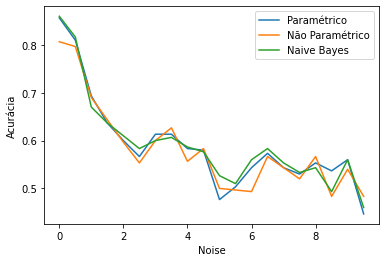

In [27]:
noises = np.arange(0,10,0.5)
x = []
for noise in np.arange(0, len(noises)):
    x.append(comparar(noises[noise]))  
x = np.array(x)



###Gráfico para comparação
plt.clf()#"Limpar" Gráfico

plt.plot(noises, x[:,0], label = "Paramétrico")

plt.plot(noises, x[:,1], label = "Não Paramétrico")

plt.plot(noises, x[:,2], label = "Naive Bayes")

plt.xlabel('Noise')

plt.ylabel('Acurácia')

plt.legend()

plt.show()

Podemos perceber que, conforme aumentamos os ruídos dos dados, a acurácia de todos os estimadores tende a diminuir.

### Exercício 4 

#### Considerando os dados artificiais do exercício anterior, mostre as regiões de separação para os métodos Naive Bayes, k-vizinhos e regressão logística.

In [28]:
X,y = datafun(0.2)

#### - K-vizinhos (k = 20 e k = 500)

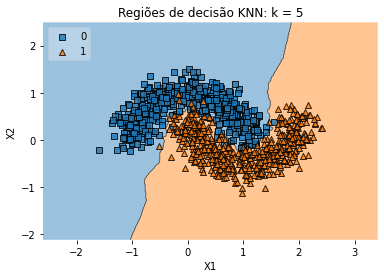

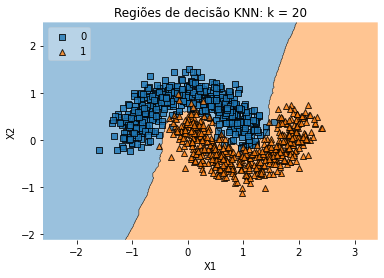

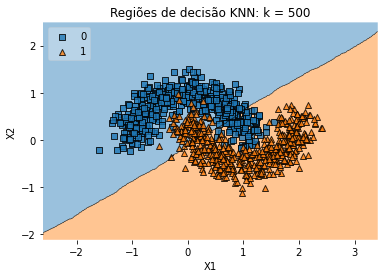

In [29]:
# mostra as regiões de separação para diversos valores de k
vk = [5,20,int(1000/2)]
for k in vk:
    # Training a classifier
    model = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
    model.fit(X, y)
    # Plotting decision regions
    plot_decision_regions(X, y, clf=model, legend=2)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title('Regiões de decisão KNN: k = '+str(k))
    plt.show()

#### - Regressão Logística

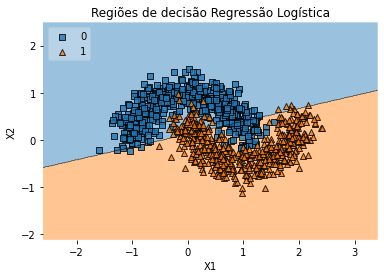

In [30]:
model = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter = 1000)
model.fit(X, y)
# Plotting decision regions
plot_decision_regions(X, y, clf=model, legend=2)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Regiões de decisão Regressão Logística')
plt.show()

#### - Naive Bayes

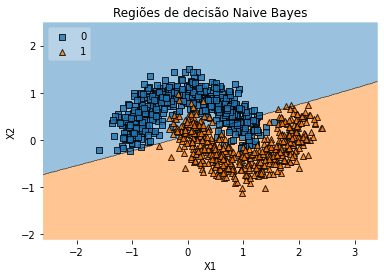

In [31]:
# Training a classifier
model = GaussianNB()
model.fit(X, y)

# Plotting decision regions
plot_decision_regions(X, y, clf=model, legend=2)

plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Regiões de decisão Naive Bayes')
plt.show()

Podemos perceber que utilizando um ruido de 0.2, as regiões de decição para os métodos Naive Bayes, Regressão Logística e KNN com K = 500 são bem parecidas, todas apresentando formas bem suaves, porém com uma leve diferença quanto a "inclinção" da divisão para o método KNN com k = 500. Já analisando as regiões para o meétodo KNN com K = 20 e k = 5, podemos perceber uma maior alteração das regiões, devido ao hiperparâmetro k ser menor,o que leva ao método a se ajustar muito aos dados, podendo causar overfitting.

### Exercício 5

#### Exercício 5: Gere dois conjuntos de pontos em duas dimensões usando o código a seguir:

In [32]:
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt

import random
# Fixando uma semente
random.seed(2020) 

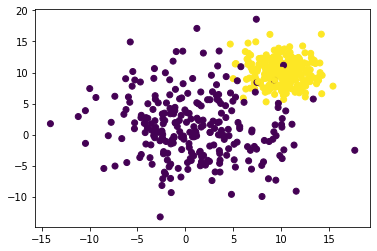

In [33]:
n = 500
c1 = [(1,1), (10,10)] #center of the points
std = [5.0, 2] # standard deviation
nc = [400,50] #number of points in each class
X, y = make_blobs(n_samples=n, n_features=2, cluster_std=std,centers= c1)
plt.scatter(X[:,0],X[:,1], c=y)
plt.show(True)

Inicialmente, vamos importar os pacotes que serão utilizados ao longo do exercício.

In [34]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import RepeatedKFold
from sklearn.naive_bayes import GaussianNB

## Naive bayes

In [35]:
# Função que calcula a acurácia do classificador Naive Bayes
def classificador_naivebayes(x_train, y_train, x_test, y_test):
    model = GaussianNB()
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)
    score = accuracy_score(y_pred, y_test)

    return score

## Bayesiano Paramétrico

In [36]:
# Função que calcula a acurácia do classificador Bayesiano Paramétrico
def classificador_bayesianoparametrico(x_train, y_train, x_test, y_test, classes):
    P = pd.DataFrame(data=np.zeros((x_train.shape[0], len(classes))), columns = classes) 

    Pc = np.zeros(len(classes)) # Armazena a fracao de elementos em cada classe
    for i in np.arange(0, len(classes)): # Para cada classe
        elements = tuple(np.where(y_train == classes[i])) # elmentos na classe i
        Pc[i] = len(elements)/len(y_train) # Probabilidade pertencer a classe i
        Z = x_train[elements,:][0] # Elementos no conjunto de treinamento
        m = np.mean(Z, axis = 0) # Vetor media
        cv = np.cov(np.transpose(Z)) # Matriz de covariancia
        for j in np.arange(0,x_test.shape[0]): # para cada observacao no conjunto de teste
            x = x_test[j,:]
            # probabilidade pertencer a cada classe
            pj = multivariate_normal.pdf(x, mean=m, cov=cv, allow_singular=True)
            P[classes[i]][j] = pj*Pc[i]
        
    y_pred = [] 
    for i in np.arange(0, x_test.shape[0]):
        c = np.argmax(np.array(P.iloc[[i]]))
        y_pred.append(classes[c])

    y_pred = np.array(y_pred, dtype=str)
    
    score = accuracy_score(y_pred, y_test)

    return score

## Comparação

Comparação dos classificadores Naive Bayes e Bayesiano Paramétrico variando a separação entre as nuvens de pontos - mantendo a posição de uma classe fixa e mudando a posição do centro da outra classe, calculando a distância entre os centros.


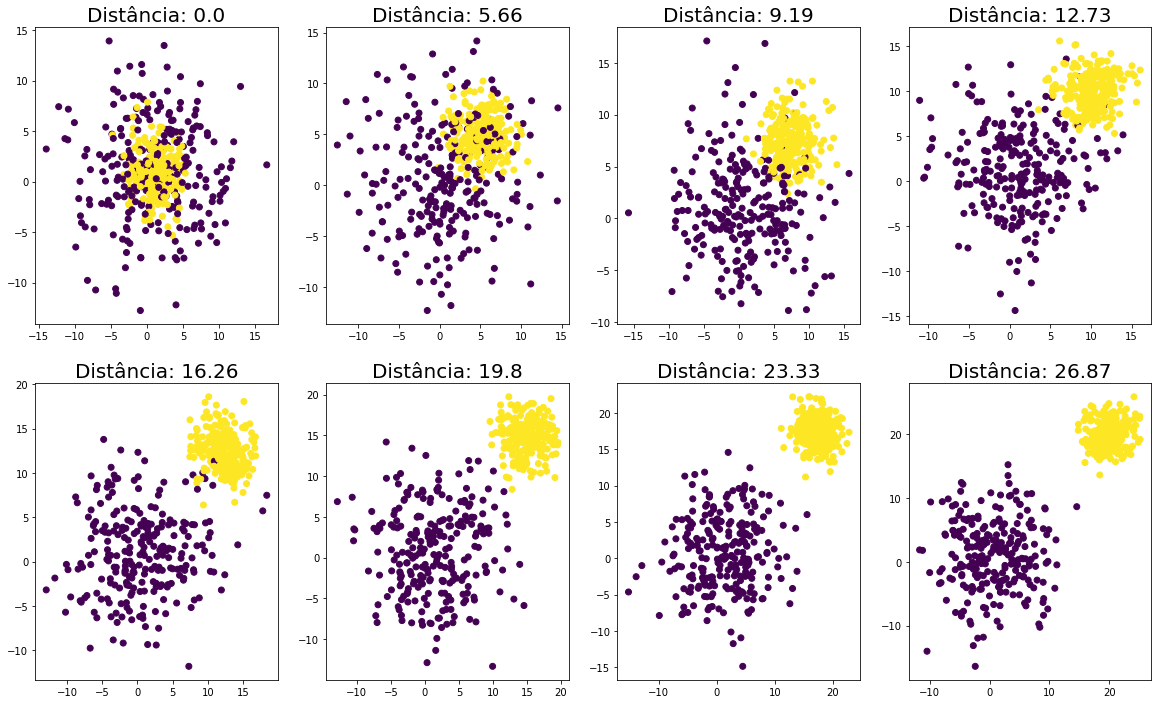

In [37]:
random_state = 2020

n = 500
c2 = [(1,1),(5,5),(7.5,7.5),(10,10),(12.5,12.5),(15,15),(17.5,17.5),(20,20)] #center of the points
std = [5.0, 2] # standard deviation
nc = [400,50] #number of points in each class
plt.figure(figsize=(20, 12))
j = 1

# Gerar os dados para 7 distâncias diferentes (sem incluir a distância com ele mesmo)
Bscore = pd.DataFrame()
NBscore = pd.DataFrame()
indices = range(0,100)
classes = ['0','1']
rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=random_state)

for i in c2:
    c = [(1,1), i] #center of the points
    X, y = make_blobs(n_samples=n, n_features=2, cluster_std=std,centers=c)
    plt.subplot(2, 4, j)
    plt.scatter(X[:,0],X[:,1], c=y)
    distancia = str(round(math.sqrt((c1[0][0]-i[0])**2+(c1[0][1]-i[1])**2),2))
    title = "Distância: "+distancia
    plt.title(title, fontsize=20)
    j += 1
    y = np.char.mod('%d', y)
    tempB = []
    tempNB = []

    # validação cruzada com 10-folds repetida 10 vezes
    for train, test in rkf.split(X,y):  
        x_train = X[train,]
        x_test = X[test,]
        y_train = y[train]
        y_test = y[test]
        tempB.append(classificador_bayesianoparametrico(x_train, y_train, x_test, y_test, classes))
        tempNB.append(classificador_naivebayes(x_train, y_train, x_test, y_test))
    Bscore[distancia] = tempB
    NBscore[distancia] = tempNB
plt.show()


Portanto, foram construídos boxplots para melhor visualização dos classficadores Naive Bayes e Bayesiano Paramétrico testados com os 8 conjuntos de dados usando 10 validações cruzadas de 10-folds.

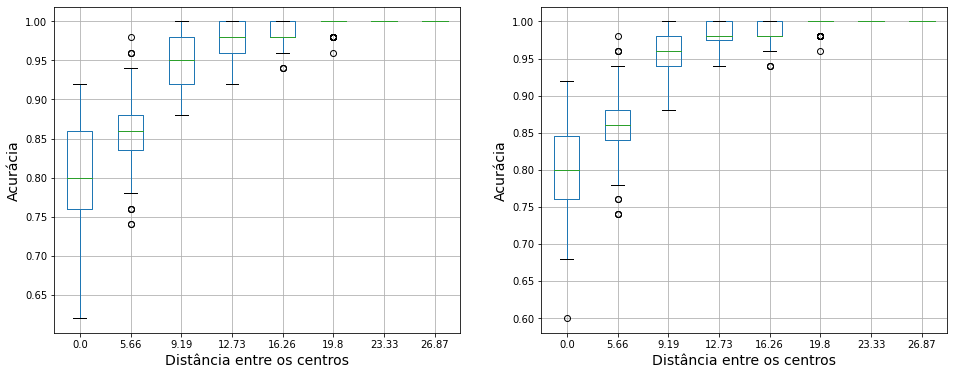

In [40]:
plt.figure(figsize=(16, 6))

# Boxplot classificador Bayesiano Paramétrico
plt.subplot(1,2,1)
Bscore.boxplot()
plt.xlabel("Distância entre os centros",fontsize=14)
plt.ylabel("Acurácia",fontsize=14)

# Boxplot classificador Naive Bayes
plt.subplot(1,2,2)
NBscore.boxplot()
plt.xlabel("Distância entre os centros",fontsize=14)
plt.ylabel("Acurácia",fontsize=14)
plt.show()

In [43]:
# Algumas medidas descritivas
resumo_BayesianoParametrico = pd.DataFrame()
resumo_BayesianoParametrico['Média Bayesiano'] = round(Bscore.mean(),2)
resumo_BayesianoParametrico['Std Bayesiano'] = round(Bscore.std(),2)
resumo_BayesianoParametrico['Média Naive Bayes'] = round(NBscore.mean(),2)
resumo_BayesianoParametrico['Std Naive Bayes'] = round(NBscore.std(),2)
print(resumo_BayesianoParametrico)

       Média Bayesiano  Std Bayesiano  Média Naive Bayes  Std Naive Bayes
0.0               0.81           0.06               0.81             0.06
5.66              0.86           0.05               0.86             0.05
9.19              0.95           0.03               0.95             0.03
12.73             0.98           0.02               0.98             0.02
16.26             0.98           0.02               0.98             0.02
19.8              1.00           0.01               1.00             0.01
23.33             1.00           0.00               1.00             0.00
26.87             1.00           0.00               1.00             0.00


A partir dos gráficos e dos valores expostos acima, nota-se que os dois classificadores analisados (Bayesiano Paramétrico e naive Bayes) têm acurácia bem parecidas, sendo muitas iguais, para os oito conjunto de dados com diferentes separações entre as nuvens de pontos. Isso pode ter ocorrido pela falta ou pequena correlação entre as variáveis, e dessa forma, a distribuição conjunta seria o produto das distribuições parciais das variáveis e também porque dos classificadores comparados apenas o Naive Bayes assume a independência de variáveis, logo, a distribuição conjunta dos dois classificadores se resume ao produto das distribuições de $X_1$ e $X_2$.

Além disso, como era de se esperar quanto maior a distância entre os centros das classes maior a acurácia dos classificadores.

É importante se atentar no desbalanceamento das classes ao interpretar a acurácia. Considerando a distânca 0 entre os centros a acurácia é maior que 50%, visto que as classes não são balanceadas, então, caso o método arriscasse que todos as observações fossem da classe majoritária, ele acertaria mais da metade.

### Exercício 6

#### Vamos gerar dois conjuntos de pontos em duas dimensões usando o código a seguir.

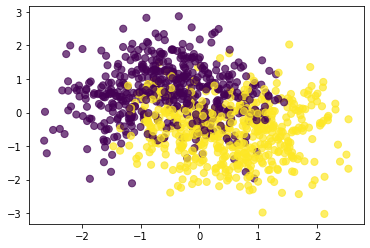

In [44]:
def amostra (ruido=0.5):
    random.seed(10691817)
    scaler = StandardScaler()
    plt.figure(figsize=(6,4))
    n_samples = 1000
    data = datasets.make_moons(n_samples=n_samples, noise=ruido)
    X = data[0]
    scaler.fit(X)
    X = scaler.transform(X)
    y = data[1]
    plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50, alpha=0.7)
    plt.show(True)
    return X, y
X, y = amostra()
p=0.7
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = p, random_state = 42)

#### Vamos comparar os classificadores Naive Bayes, k-vizinhos mais próximos e regressão logística variando o nível de ruído(noise) no intervalo [0,1]. No caso do algoritmo k-vizinho, usaremos o método selection.GridSearchCV da biblioteca sciki-learn para determinar a melhor medida de distância e o valor de k.

#### - Naive Bayes

In [45]:
def classNaivesBayes (X_train, X_test, y_train, y_test ):
    classes = pd.unique(y_train)
    classes = np.array(classes, dtype=int)  
    def likelyhood(y, Z):
        def gaussian(x, mu, sig):
            return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
        prob = 1
        for j in np.arange(0, Z.shape[1]):
            m = np.mean(Z[:,j])
            s = np.std(Z[:,j])      
            prob = prob*gaussian(y[j], m, s)
        return prob
    # matriz que armazena o produto da verossimilhanca pela priori
    P = pd.DataFrame(data=np.zeros((X_test.shape[0], len(classes))), columns = classes) 
    for i in np.arange(0, len(classes)):
        elements = tuple(np.where(y_train == classes[i]))
        Z = X_train[elements,:][0]
        for j in np.arange(0,X_test.shape[0]):
            x = X_test[j,:]
            pj = likelyhood(x,Z) #verossimilhanca
            pc = len(elements)/X_train.shape[0] # priori
            P[classes[i]][j] = pj*pc
        
    # realiza a classificao seguindo a regra de Bayes
    y_pred = []
    for i in np.arange(0, P.shape[0]):
        c = np.argmax(np.array(P.iloc[[i]]))
        y_pred.append(P.columns[c])
    y_pred = np.array(y_pred, dtype=int)
    # calcula a acuracia na classificacao
    score = accuracy_score(y_pred, y_test)
    print('Acurácia Naives bayes:', score)

#### - k-vizinhos

Código para encontrar os melhores parâmetros para o algoritmo.

In [46]:
param_grid = {'n_neighbors': np.arange(1, 50)}
knn = KNeighborsClassifier() 
knn_cv = GridSearchCV(knn, param_grid, cv=5)
knn_cv.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [47]:
def knnClassifier(X_train, X_test, y_train, y_test ):
    model = KNeighborsClassifier(n_neighbors=knn_cv.best_params_["n_neighbors"], metric = 'euclidean')
    model.fit(X_train,y_train)
    # faz a predição no conjunto de teste
    y_pred = model.predict(X_test) 
    # verifica a acurácia da predicao
    score = accuracy_score(y_pred, y_test)
    print('Acurácia Knn:', score)

In [48]:
def logisticRegression(x_train, x_test, y_train, y_test):
    model = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter = 1000)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print('Acurácia Regressão logística: ', model.score(x_test, y_test))

#### - Comparação

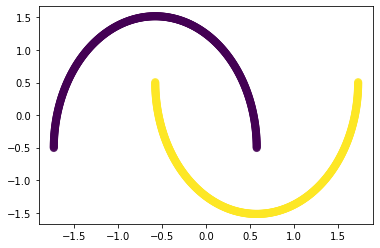

Acurácia Naives bayes: 0.8833333333333333
Acurácia Knn: 1.0
Acurácia Regressão logística:  0.8933333333333333


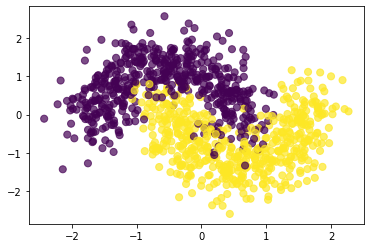

Acurácia Naives bayes: 0.86
Acurácia Knn: 0.9466666666666667
Acurácia Regressão logística:  0.8533333333333334


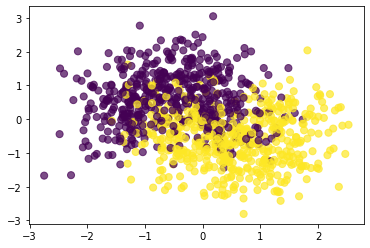

Acurácia Naives bayes: 0.8433333333333334
Acurácia Knn: 0.84
Acurácia Regressão logística:  0.8466666666666667


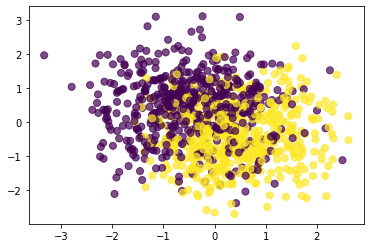

Acurácia Naives bayes: 0.7666666666666667
Acurácia Knn: 0.7733333333333333
Acurácia Regressão logística:  0.7666666666666667


In [49]:
for i in np.arange(0.0, 1.0, 0.25):
    X, y = amostra(i)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = p, random_state = 42)
    classNaivesBayes(X_train, X_test, y_train, y_test)
    knnClassifier(X_train, X_test, y_train, y_test)
    logisticRegression(X_train, X_test, y_train, y_test)

#### - Conclusão

Podemos perceber que quanto menor o ruído na nossa amostra, melhores resultados o algoritmo KNN apresenta, e essa mudança na acurácia, é bem considerável. Já para a Regressão Logística, mesmo a acurácia dela diminuindo conforme aumentamos o ruído, essa mudança não é tão grande, o mesmo para o Naive Bayes.

### Exercício 7

#### Considerando os dados do código anterior, vamos comparar os algoritmos: arvores de decisão, florestas aleatórias e bagging. 


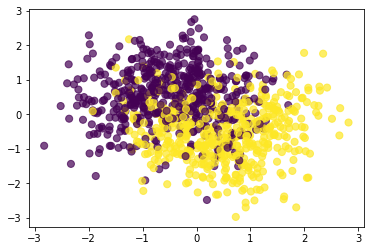

In [50]:
def amostra (ruido=0.5):
    random.seed(10691817)
    scaler = StandardScaler()
    plt.figure(figsize=(6,4))
    n_samples = 1000
    data = datasets.make_moons(n_samples=n_samples, noise=ruido)
    X = data[0]
    scaler.fit(X)
    X = scaler.transform(X)
    y = data[1]
    plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50, alpha=0.7)
    plt.show(True)
    return X, y
X, y = amostra()
p=0.7
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = p, random_state = 42)

#### - Árvores de decisão

In [118]:
from sklearn import tree
# Cria o modelo usando o criterio Gini, antes de definir o melhor critério com GridSearch
model = tree.DecisionTreeClassifier(criterion = 'gini', random_state = 101)

# Ajusta o modelo usando os dados de treinamento
model.fit(x_train,y_train)

# realizar a predição
y_pred = model.predict(x_test) 

Usando a medida de acurácia, avaliamos o desempenho do modelo no aprendizado.

In [119]:
from sklearn.metrics import accuracy_score
score = accuracy_score(y_pred, y_test)
print('Accuracy:', score)

Accuracy: 0.7633333333333333


Vamos visualizar a árvore:

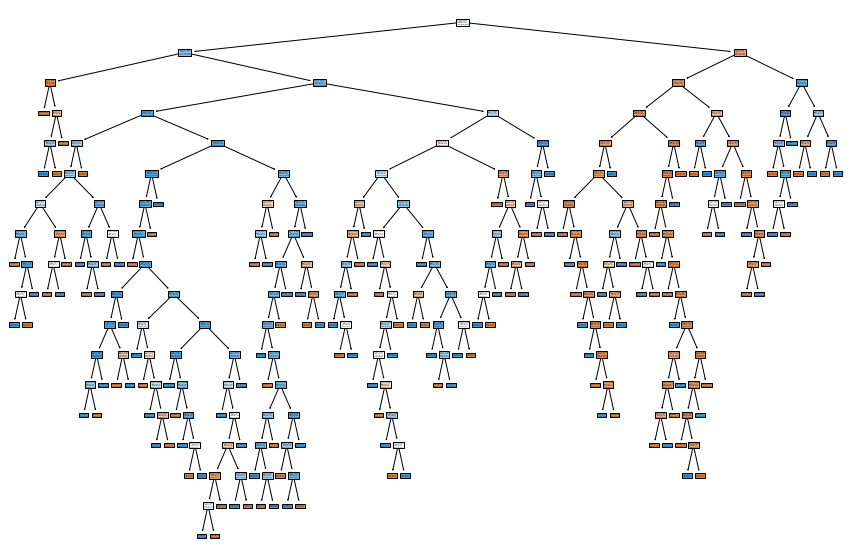

In [116]:
plt.figure(figsize=(15,10))
tree.plot_tree(model.fit(x_train,y_train),filled=True)
plt.show(True)

#### - Florestas Aleatórias (Random Forest)

O método florestas aleatórias considera amostragem de observações e atributos. Vamos realizar a classificação.

In [120]:
from sklearn.ensemble import RandomForestClassifier

# define os parâmetros do modelo
model=RandomForestClassifier(n_estimators=100, bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_jobs=1,
            oob_score=False, random_state=101, verbose=0,
            warm_start=False)
model.fit(x_train,y_train)

#Predict the response for test dataset
y_pred = model.predict(x_test)
score = accuracy_score(y_pred, y_test)
print('Accuracy:', score)

Accuracy: 0.7933333333333333


É possível perceber que o número de árvores influencia no resultado (acurácia).

Number of Estimators: 1 Accuracy: 0.7266666666666667
Number of Estimators: 11 Accuracy: 0.7833333333333333
Number of Estimators: 21 Accuracy: 0.78
Number of Estimators: 31 Accuracy: 0.7766666666666666
Number of Estimators: 41 Accuracy: 0.7933333333333333
Number of Estimators: 51 Accuracy: 0.7933333333333333
Number of Estimators: 61 Accuracy: 0.7966666666666666
Number of Estimators: 71 Accuracy: 0.7933333333333333
Number of Estimators: 81 Accuracy: 0.7966666666666666
Number of Estimators: 91 Accuracy: 0.79
Melhor n: 61  com acurácia: 0.7966666666666666


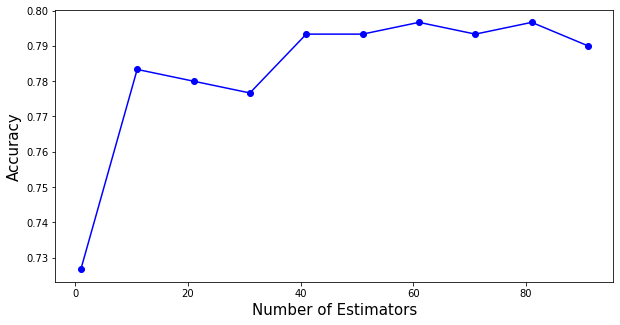

In [121]:
vscore = []
vn = []
for n in range(1,100,10):
    model = RandomForestClassifier(n_estimators=n,random_state = 101)
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test) 
    score = accuracy_score(y_pred, y_test)
    print('Number of Estimators:', n, 'Accuracy:', score)
    vscore.append(score)
    vn.append(n)
best_n = vn[np.argmax(vscore)]
print('Melhor n:', best_n, ' com acurácia:', vscore[np.argmax(vscore)] )
plt.figure(figsize=(10,5))
plt.plot(vn, vscore, '-bo')
plt.xlabel('Number of Estimators', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.show()

Portanto, o melhor número de estimadores é 61 dentre os outros testados, pois a acurácia é a maior.


#### - Bagging

O método bagging (Bootstrap Aggregating) permite que geremos amostrar a partir dos dados iniciais, de modo a reduzir a variância em classificadores com baixo viés.

Realizando a classificação, temos:

In [122]:
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification

#chama o classificador
model = BaggingClassifier(base_estimator=tree.DecisionTreeClassifier(criterion = 'entropy', random_state = 101),
                          n_estimators=10, random_state = 101)
model.fit(x_train,y_train)
# faz a predição no conjunto de teste
y_pred = model.predict(x_test) 
# calcula a acurácia do modelo
score = accuracy_score(y_pred, y_test)
print('Accuracy:', score)

Accuracy: 0.8066666666666666


Comparando os modelos antes de escolher os melhores hiperparâmetros, temos que o modelo de Bagging se saiu como o melhor entre os 3.

Agora, usaremos o método selection.GridSearchCV da biblioteca sciki-learn para determinar os melhores parâmetros dos modelos.

#### - Árvore de decisão


In [123]:
from sklearn.model_selection import GridSearchCV
from sklearn import tree
decisionTree = tree.DecisionTreeClassifier(random_state = 101) 
param_grid = {'criterion':['gini','entropy'],'max_depth':range(4,50)}
decisionTree_cv = GridSearchCV(decisionTree, param_grid, cv=5)
decisionTree_cv.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=101,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(4, 50)},
             pre_dispatch

In [124]:
decisionTree_cv.best_params_

{'criterion': 'gini', 'max_depth': 5}

Portanto, o melhor parâmetro, utilizando o critério gini, é 5.
Vamos substituí-lo no modelo de árvore de decisão e obter a acurácia.

In [125]:
model_decisiontree_best_params = tree.DecisionTreeClassifier(criterion = 'gini',max_depth=5, random_state = 101)

# Ajuste do modelo usando os dados de treinamento
model_decisiontree_best_params.fit(x_train,y_train)

# Predição
y_pred = model_decisiontree_best_params.predict(x_test) 

# Acurácia
score = accuracy_score(y_pred, y_test)
print('Accuracy:', score)

Accuracy: 0.8066666666666666


A acurácia deste modelo é realmente melhor do que a árvore de decisão implementada anteriormente.

Vamos visualizar a árvore.

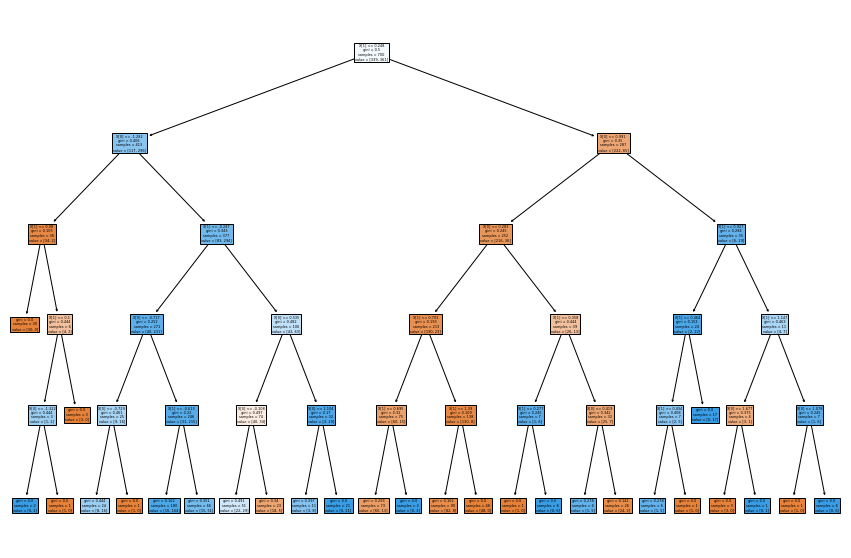

In [126]:
plt.figure(figsize=(15,10))
tree.plot_tree(model_decisiontree_best_params.fit(x_train,y_train),filled=True)
plt.show(True)

#### - Florestas Aleatórias

In [129]:
from sklearn.model_selection import GridSearchCV

decisionForest = RandomForestClassifier(random_state=101) 
param_grid = {'criterion':['gini','entropy'],'max_depth':range(4,50)}
decisionForest_cv = GridSearchCV(decisionForest, param_grid, cv=5)
decisionForest_cv.fit(X, y)

C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dougl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=101,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={

In [132]:
decisionForest_cv.best_params_

{'criterion': 'entropy', 'max_depth': 5}

Portanto, o melhor parâmetro, utilizando o critério gini, é 5. Vamos substituí-lo no modelo de florestas aleatórias e obter a acurácia.

In [133]:
from sklearn.ensemble import RandomForestClassifier

# define os parâmetros do modelo
model_randomforest_best_params=RandomForestClassifier(n_estimators=100, bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_jobs=1,
            oob_score=False, random_state=101, verbose=0,
            warm_start=False)
model_randomforest_best_params.fit(x_train,y_train)

#Predict the response for test dataset
y_pred = model_randomforest_best_params.predict(x_test)
score = accuracy_score(y_pred, y_test)
print('Accuracy:', score)

Accuracy: 0.8133333333333334


#### - Bagging

In [134]:
#Classificador
model = BaggingClassifier(base_estimator=tree.DecisionTreeClassifier(criterion = 'entropy', random_state = 101),
                          n_estimators=101)
model.fit(x_train,y_train)
# faz a predição no conjunto de teste
y_pred = model.predict(x_test) 
# calcula a acurácia do modelo
score = accuracy_score(y_pred, y_test)
print('Accuracy:', score)

Accuracy: 0.81


In [135]:
decisionBagging = BaggingClassifier(tree.DecisionTreeClassifier(random_state = 101)) 
param_grid = {    'base_estimator__max_depth' : [1, 2, 3, 4, 5],
              'base_estimator__criterion' : ['gini','entropy'],
    'max_samples' : [0.05, 0.1, 0.2, 0.5]}
decisionBagging_cv = GridSearchCV(decisionBagging, param_grid, cv=5)
decisionBagging_cv.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                                               criterion='gini',
                                                                               max_depth=None,
                                                                               max_features=None,
                                                                               max_leaf_nodes=None,
                                                                               min_impurity_decrease=0.0,
                                                                               min_impurity_split=None,
                                                                               min_samples_leaf=1,
                                                                               min_samples_split=2,
                                                   

In [136]:
decisionBagging_cv.best_params_

{'base_estimator__criterion': 'entropy',
 'base_estimator__max_depth': 5,
 'max_samples': 0.2}

In [137]:
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification

#chama o classificador
model = BaggingClassifier(base_estimator=tree.DecisionTreeClassifier(criterion = 'entropy',max_depth = 5, random_state = 106961817),max_samples=0.2)
model.fit(x_train,y_train)
# faz a predição no conjunto de teste
y_pred = model.predict(x_test) 
# calcula a acurácia do modelo
score = accuracy_score(y_pred, y_test)
print('Accuracy:', score)

Accuracy: 0.8


Comparando os modelos após escolher os melhores hiperparâmetros, temos que o modelo de Random Forest se saiu como o melhor entre os 3.

### Exercício 8


#### Exercício 8)  Considere as bases: Vehicle, winequality-red e vertebralcolumn-3C. Compare os classificadores: (a) Naive Bayes, (b) Florestas aleatórias, (c) k-vizinhos, (d) regressão logística. Considere as medidas: (i) AUC (área sob a curva ROC), (ii) precisão, (iii) medida F1 e (iv) acurácia. Ou seja, faça uma tabela para cada base, onde as linhas representam os classificadores e as colunas, as medidas de avaliação.


### Importando bibliotecas necessárias para o exercícico

In [138]:
from sklearn import datasets
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score,f1_score
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

### Base de dados Titanic

#### Importanto a base

In [159]:
with open('Titanic/train.csv') as f:
    dfTrain = pd.read_csv(f)
f.close()

In [160]:
with open('Titanic/test.csv') as f:
    dfTest = pd.read_csv(f)
f.close()

#### Definindo uma seed

In [162]:
seed = 10691817 #importante para replicar os resultados
random.seed(seed)

#### Análise explorátória básica

In [163]:
dfTrain.shape

(891, 12)

In [164]:
dfTest.shape

(418, 11)

In [165]:
dfTrain.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [166]:
print("Número de linhas e colunas no conjunto de treinamento:", dfTrain.shape)
print("Número de linhas e colunas no conjunto de teste:", dfTest.shape)
attributes = list(dfTrain.columns)
dfTrain.head(10)

Número de linhas e colunas no conjunto de treinamento: (891, 12)
Número de linhas e colunas no conjunto de teste: (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [167]:
dfTest.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


Nossa base de teste não contém a coluna que devemos inferir

### Limpeza e normalização dos dados
Vemos que alguns atributos são irrelavantes, como PassengerId, Name, Ticket e Cabin. Vamos retirar esses atributos dos conjuntos de teste e treinamento.

In [168]:
dfTrain.drop(['PassengerId','Name', 'Ticket', 'Cabin'],axis = 1, inplace = True)
dfTrain.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
5,0,3,male,NaN,0,0,8.4583,Q
6,0,1,male,54.0,0,0,51.8625,S
7,0,3,male,2.0,3,1,21.0750,S
8,1,3,female,27.0,0,2,11.1333,S
9,1,2,female,14.0,1,0,30.0708,C


In [169]:
dfTest.drop(['PassengerId','Name', 'Ticket', 'Cabin'],axis = 1, inplace = True)
dfTest.head(10)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S
5,3,male,14.0,0,0,9.2250,S
6,3,female,30.0,0,0,7.6292,Q
7,2,male,26.0,1,1,29.0000,S
8,3,female,18.0,0,0,7.2292,C
9,3,male,21.0,2,0,24.1500,S


Os atributos nominais podem ser transformados para numéricos usando one-hot-enconding.



In [170]:
dfTrain = pd.get_dummies(dfTrain)
dfTrain.head(10)

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1
5,0,3,NaN,0,0,8.4583,0,1,0,1,0
6,0,1,54.0,0,0,51.8625,0,1,0,0,1
7,0,3,2.0,3,1,21.0750,0,1,0,0,1
8,1,3,27.0,0,2,11.1333,1,0,0,0,1
9,1,2,14.0,1,0,30.0708,1,0,1,0,0


In [171]:
dfTest = pd.get_dummies(dfTest)
dfTest.head(10)

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,34.5,0,0,7.8292,0,1,0,1,0
1,3,47.0,1,0,7.0000,1,0,0,0,1
2,2,62.0,0,0,9.6875,0,1,0,1,0
3,3,27.0,0,0,8.6625,0,1,0,0,1
4,3,22.0,1,1,12.2875,1,0,0,0,1
5,3,14.0,0,0,9.2250,0,1,0,0,1
6,3,30.0,0,0,7.6292,1,0,0,1,0
7,2,26.0,1,1,29.0000,0,1,0,0,1
8,3,18.0,0,0,7.2292,1,0,1,0,0
9,3,21.0,2,0,24.1500,0,1,0,0,1


O conjunto de dados pode apresentar valores nulos (not a number: nan). A sua identificação pode ser feita usando métodos da biblioteca Pandas.

In [172]:
dfTrain.isnull().sum().sort_values(ascending=False).head(10)


Age           177
Embarked_S      0
Embarked_Q      0
Embarked_C      0
Sex_male        0
Sex_female      0
Fare            0
Parch           0
SibSp           0
Pclass          0
dtype: int64

In [173]:
dfTest.isnull().sum().sort_values(ascending=False).head(10)


Age           86
Fare           1
Embarked_S     0
Embarked_Q     0
Embarked_C     0
Sex_male       0
Sex_female     0
Parch          0
SibSp          0
Pclass         0
dtype: int64

Se removermos a linhas com esses valores, vamos perder uma grande quantidade de dados. Para não descartamos as observações que contém nan, vamos atribuir valores médios às entradas nulas.



In [174]:
# substituicao no conjunto de treinamento
averages = dfTrain.mean(axis=0)
nrow,ncol = dfTrain.shape
for i in range(0,nrow):
    for j in range(0,ncol):
        if(np.isnan(dfTrain.iloc[i,j]) == True):
            dfTrain.iloc[i,j] = averages[j]

# substituicao no conjunto de teste
averages_test = dfTest.mean(axis=0)
nrow,ncol = dfTest.shape
for i in range(0,nrow):
    for j in range(0,ncol):
        if(np.isnan(dfTest.iloc[i,j]) == True):
            dfTest.iloc[i,j] = averages_test[j]

Para facilitar o processamento, vamos converter os dados para o formato numpy para podemos realizar a classificação.



In [175]:
data_train = dfTrain.to_numpy()
nrow,ncol = data_train.shape
y = data_train[:,0]
X = data_train[:,1:ncol]

para o conjunto de teste:

In [176]:
data_test = dfTest.to_numpy()
X_test = data_test

Os dados podem ser normalizados, de modo a evitar o efeito da escala dos atributos nos métodos de aprendizado.



In [177]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

scaler = StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)

print('Dados transformados:')
print('Media: ', np.mean(X, axis = 0))
print('Desvio Padrao:', np.std(X, axis = 0))

Dados transformados:
Media:  [-8.77213254e-17  2.23290646e-16  4.38606627e-17  5.38289951e-17
  3.98733297e-18  3.98733297e-17 -1.15632656e-16 -1.99366649e-17
  0.00000000e+00 -4.98416622e-17]
Desvio Padrao: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


#### Implementando os classificadores 

##### 1- Naives bayes

In [180]:
def naivesBayesResult (xTrain, xTest, yTrain, yTest ) :
    model = GaussianNB()
    model.fit(xTrain, yTrain)
    yPred = model.predict(xTest)
    acurracy = accuracy_score(yPred, yTest)
    aucUnderRoc = roc_auc_score(yPred, yTest)
    precision = precision_score(yPred, yTest, average="macro")
    f1Score = f1_score(yPred, yTest, average="macro")
    return {'Classificador':'Naives Bayes', 'AUC':aucUnderRoc, 'Precisão':precision, 'F1-Score':f1Score, 'Acúracia':acurracy }

##### 2-  Florestas aleatórias

In [181]:
def randomForestResult (xTrain, xTest, yTrain, yTest ) :
    model = RandomForestClassifier(n_estimators=100, bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
    model.fit(xTrain, yTrain)
    yPred = model.predict(xTest)
    acurracy = accuracy_score(yPred, yTest)
    aucUnderRoc = roc_auc_score(yPred, yTest)
    precision = precision_score(yPred, yTest, average="macro")
    f1Score = f1_score(yPred, yTest, average="macro")
    return {'Classificador':'Floresta aleatória', 'AUC':aucUnderRoc, 'Precisão':precision, 'F1-Score':f1Score, 'Acúracia':acurracy }

##### 3-   k-vizinhos

In [182]:
def knnResult (xTrain, xTest, yTrain, yTest ) :
    param_grid = {'n_neighbors': np.arange(1, 50)}
    knn = KNeighborsClassifier() 
    knn_cv = GridSearchCV(knn, param_grid, cv=5)
    knn_cv.fit(X, y)
    model = KNeighborsClassifier(n_neighbors=knn_cv.best_params_["n_neighbors"], metric = 'euclidean')
    model.fit(xTrain, yTrain)
    yPred = model.predict(xTest)
    acurracy = accuracy_score(yPred, yTest)
    aucUnderRoc = roc_auc_score(yPred, yTest)
    precision = precision_score(yPred, yTest, average="macro")
    f1Score = f1_score(yPred, yTest, average="macro")
    return {'Classificador':'k-vizinhos', 'AUC':aucUnderRoc, 'Precisão':precision, 'F1-Score':f1Score, 'Acúracia':acurracy }

##### 4-   Regressão logística

In [183]:
def logisticRegressionResult (xTrain, xTest, yTrain, yTest ) :
    model = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter = 1000)
    model.fit(xTrain, yTrain)
    yPred = model.predict(xTest)
    acurracy = accuracy_score(yPred, yTest)
    aucUnderRoc = roc_auc_score(yPred, yTest)
    precision = precision_score(yPred, yTest, average="macro")
    f1Score = f1_score(yPred, yTest, average="macro")
    return {'Classificador':'Regressão logística', 'AUC':aucUnderRoc, 'Precisão':precision, 'F1-Score':f1Score, 'Acúracia':acurracy }

#### Montando o conjunto de teste e de treino

#### Criando os conjuntos a partir da validação cruzada

Como o nossos dados de teste nao possui a classe alvo usaremos apenas a de treino para usar os classificadore

In [184]:
p=0.3
xTrain, xTest, yTrain, yTest = train_test_split(X, y, train_size = p, random_state = 42)

#### Rodando os modelos

In [185]:
naivesLine=naivesBayesResult(xTrain, xTest, yTrain, yTest)
randomLine=randomForestResult(xTrain, xTest, yTrain, yTest)
knnLine=knnResult(xTrain, xTest, yTrain, yTest)
logisticLine=logisticRegressionResult(xTrain, xTest, yTrain, yTest)
dfResult = pd.DataFrame(data=naivesLine, index=[0])
dfResult=dfResult.append(randomLine,ignore_index=True)
dfResult=dfResult.append(knnLine,ignore_index=True)
dfResult=dfResult.append(logisticLine,ignore_index=True)
dfResult

,Classificador,AUC,Precisão,F1-Score,Acúracia
0,Naives Bayes,0.742084,0.750582,0.744364,0.751603
1,Floresta aleatória,0.771256,0.770449,0.770843,0.782051
2,k-vizinhos,0.795996,0.766307,0.774869,0.794872
3,Regressão logística,0.794339,0.783305,0.787669,0.801282


Temos que a regressão logística apresenta o melhor resultado.

## Exercício 9
#### Considere os código abaixo. Avalie como o desbalanceamento influencia nos resultados usando as medidas i) AUC (área sob a curva ROC), (ii) precisão, (iii) medida F1 e (iv) acurácia. Elabore um estudo e proceda com o desenvolvimento dos códigos. Dica: use o método de validação cruzada estratificado na classificação e discuta a comparação com o caso sem o uso de estratificação.

In [186]:
#Bibliotecas que serão utilizadas.
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
random.seed(42)

Counter({0: 9900, 1: 100})


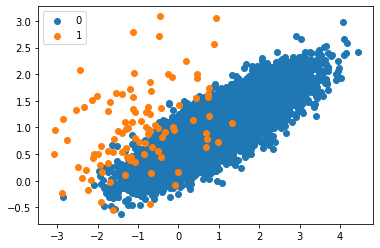

In [187]:
# Generate and plot a synthetic imbalanced classification dataset
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where
import numpy as np # manipular arrays

# define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
# summarize class distribution
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = where(y == label)[0]
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

Nota-se um grande desbalanceamento das classes, com 99% das observações sendo da classe 0 e o restante da classe 1. Essa particularidade pode afetar no treinamento de um modelo, pois há poucos valores para representar a classe minoritária.

Definindo a função que separa o conjunto em treino e teste a seguir:

In [188]:
# Função que separa um conjunto de dados em dados de treino e teste com a possibilidade de se padronizar os dados antes de separa-los
def padroniza_e_treino_teste(covariaveis,
                             variavel_resposta,
                             padroniza = "sim",
                             semente = 42,
                             proporcao_treino = 0.8):

  from sklearn.model_selection import train_test_split # separar em dados de treino e teste
  from sklearn.preprocessing import StandardScaler # pra normalizar os dados

  if(padroniza == "sim"):
    # Transforma os dados para terem media igual a zero e variancia igual a 1
    scaler = StandardScaler().fit(covariaveis)
    covariaveis = scaler.transform(covariaveis)

  x_train, x_test, y_train, y_test = train_test_split(covariaveis,
                                                     variavel_resposta,
                                                     train_size = proporcao_treino,
                                                     random_state = semente)
  
  return x_train, x_test, y_train, y_test

Então, vamos, inicialmente, aplicar um modelo comum de árvores sem nenhuma técnica para tratar o desbalanceamento dos dados para comparar posteriormente com os resultados considerando alguma técnica que considera o desbalanceamento.

In [189]:
from sklearn import tree # modelo arvores de decisao

# Dividir os dados em treino e teste
x_train, x_test, y_train, y_test = padroniza_e_treino_teste(X,y)

# Mdelo de árovore de decisão com o critério Gini
model = tree.DecisionTreeClassifier(criterion = 'gini', random_state = 42)

# Ajuste do modelo com os dados de treino
model.fit(x_train,y_train)

# Predição
y_pred = model.predict(x_test) 

Agora que o modelo foi ajustado, vamos plotar algumas medidas para interpretação.

In [191]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[1972,   11],
       [   9,    8]], dtype=int64)

In [192]:
from sklearn.metrics import roc_auc_score # calculo de curva ROC
from sklearn.metrics import precision_score # calculo da precisao 
from sklearn.metrics import f1_score # calculo da medida f1
from sklearn.metrics import accuracy_score # calculo de acuracia

auc = roc_auc_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Área abaixo da curva ROC:", auc, "\n",
      "Precisão:", precision, "\n",
      "Medida F1:", f1, "\n",
      "Acurácia:", accuracy)

Área abaixo da curva ROC: 0.7325205422562369 
 Precisão: 0.42105263157894735 
 Medida F1: 0.4444444444444444 
 Acurácia: 0.99


Levando em conta o modelo de árvore sem nenhuma técnica para tratamento do desbalanceamento, podemos perceber que a acurácia resultou em um valor elevado, mas essa métrica não é a ideal para avaliar esse tipo de problema em que temos classes desbalanceadas, portanto, vamos nos basear nas outras medidas. É interessante notar que a precisão deu baixa, ou seja, os valores estão sendo preditos como da classe 0 quando são verdadeiramente da classe 1, devido a nossa classe 1 ser a com menor proporção.

Então, para contornarmos esse problema e compararmos os valores obtidos acima, vamos utilizar o método de validação cruzada estratificada, visto que é um método que leva em consideração o desbalanceamento dos dados. Havia muitas outras técnicas possíveis, tais como de sampling: undersampling e oversampling, que consistem em balancear o conjunto de dados por meio da eliminação de exemplos da classe majoritária e ''gerar'' a classe minoritária até que ela fique numa proporção mais condizente com a da classe majoritária, respectivamente.

In [193]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
vacc = []
vauc = []
vprecision = []
vf1 = []
for train_index, test_index in cv.split(X, y):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = tree.DecisionTreeClassifier(criterion = 'gini')
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test) 
    score = accuracy_score(y_pred, y_test)
    vacc.append(score)
    auc = roc_auc_score(y_test, y_pred)
    vauc.append(auc)
    precision = precision_score(y_test, y_pred)
    vprecision.append(precision)
    f1 = f1_score(y_test, y_pred)
    vf1.append(f1)

In [194]:
print("Área média abaixo da curva ROC:", np.mean(vauc), "\n",
      "Precisão média:", np.mean(vprecision), "\n",
      "Medida F1 média:", np.mean(vf1), "\n",
      "Acurácia média:",  np.mean(vacc))

Área média abaixo da curva ROC: 0.7522727272727272 
 Precisão média: 0.5008843933843934 
 Medida F1 média: 0.4970415940829187 
 Acurácia média: 0.9897


Observando as métricas obtidas após o método de validação cruzada estratificado na classificação, é possível perceber uma melhora de todas. Analisando, em especial, a precisão houve uma pequeno aumento, porém o valora ainda é baixo. Logo, sugerimos testar o uso de outros métodos que trabalhem com o desbalanceamento dos dados.

## Exercício 10

#### Realize a classificação da base Titanic. Use os métodos de seleção de modelos e determine o melhor modelo e seus hiperparâmetros.

In [ ]:
#Entrada dos dos dados.
train1 = pd.read_csv('Titanic/train.csv', header=(0))
test1 = pd.read_csv('Titanic/test.csv', header=(0))
#Visualização dos dados.
print("Número de linhas e colunas no conjunto de treinamento:", train1.shape)
print("Número de linhas e colunas no conjunto de teste:", test1.shape)
attributes = list(train1.columns)
train1.head(10)

Número de linhas e colunas no conjunto de treinamento: (891, 12)
Número de linhas e colunas no conjunto de teste: (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [ ]:
#Removendo colunas que não serão utilizadas na classificação.
train1.drop(['PassengerId','Name', 'Ticket', 'Cabin'],axis = 1, inplace = True)
PassengerId_test = test1['PassengerId']
test1.drop(['PassengerId','Name', 'Ticket', 'Cabin'],axis = 1, inplace = True)


In [ ]:
#Transformando variáveis categórias em dummies.
train = pd.get_dummies(train1)
test = pd.get_dummies(test1)
train.head(10)

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1
5,0,3,NaN,0,0,8.4583,0,1,0,1,0
6,0,1,54.0,0,0,51.8625,0,1,0,0,1
7,0,3,2.0,3,1,21.0750,0,1,0,0,1
8,1,3,27.0,0,2,11.1333,1,0,0,0,1
9,1,2,14.0,1,0,30.0708,1,0,1,0,0


In [ ]:
#Checando se há valores nulos no dataset.
print('\n Treino \n')
print(train.isnull().sum().sort_values(ascending=False).head(10))
print('\n Teste \n')
print(test.isnull().sum().sort_values(ascending=False).head(10))


 Treino 

Age           177
Embarked_S      0
Embarked_Q      0
Embarked_C      0
Sex_male        0
Sex_female      0
Fare            0
Parch           0
SibSp           0
Pclass          0
dtype: int64

 Teste 

Age           86
Fare           1
Embarked_S     0
Embarked_Q     0
Embarked_C     0
Sex_male       0
Sex_female     0
Parch          0
SibSp          0
Pclass         0
dtype: int64


Como podemos observar, há uma grande quantidade de valores nulos em relação a idade das pessoas, para isso, vamos fazer a substituição desses valores nulos pela média da idade.

In [ ]:
#Vamos substituir os valores nulos pelas médias de cada coluna.
# substituicao no conjunto de treinamento
averages = train.mean(axis=0)
nrow,ncol = train.shape
for i in range(0,nrow):
    for j in range(0,ncol):
        if(np.isnan(train.iloc[i,j]) == True):
            train.iloc[i,j] = averages[j]

# substituicao no conjunto de teste
averages_test = test.mean(axis=0)
nrow,ncol = test.shape
for i in range(0,nrow):
    for j in range(0,ncol):
        if(np.isnan(test.iloc[i,j]) == True):
            test.iloc[i,j] = averages_test[j]

In [ ]:
#Passando os dados para numpy.
#Treino
data_train = train.to_numpy()
nrow,ncol = data_train.shape
y = data_train[:,0]
X = data_train[:,1:ncol]
#Test
data_test = test.to_numpy()
X_test = data_test

In [ ]:
#Padronização dos dados.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

scaler = StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)

print('Dados transformados:')
print('Media: ', np.mean(X, axis = 0))
print('Desvio Padrao:', np.std(X, axis = 0))

Dados transformados:
Media:  [-8.77213254e-17  2.23290646e-16  4.38606627e-17  5.38289951e-17
  3.98733297e-18  3.98733297e-17 -1.15632656e-16 -1.99366649e-17
  0.00000000e+00 -4.98416622e-17]
Desvio Padrao: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


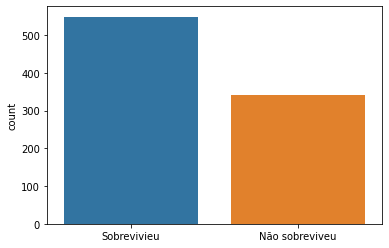

In [ ]:
#Checando o desbalaceamento dos dados
g = sns.countplot(y)
g.set_xticklabels(['Sobrevivieu','Não sobreviveu'])
plt.show()

Podemos perceber que há desbalanceamento em relação as classes.

# Classificação.
Iremos aqui utilizar diversos métodos de classificação para encontrar o que produz um melhor resultado (analisando no Kaggle), iremos também utilizar métodos de seleção de modelos (encontrar o melhor valor dos hiperparâmetros) e validar os modelos adequadamente. Vamos utilziar métodos como KNN, Random Forest e SVM que possuem hiperarâmetros, para que possamos fazer uma análise em relação aos hiperparâmetros. Mas também vamos utilizar Regressão Logística e Naive Bayes, para podemos comparar os 5 métodos e tentar tirar algum 'insight' através dos resultados obtidos (e também para fazer algo diferente do que o professor já havia feito).


# KNN

Melhor k: 16  AUC: 0.7989166171519113


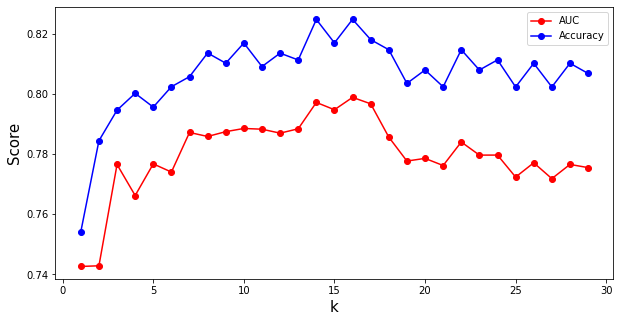

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
mauc = []
macc = []
vk = []
for k in range(1, 30):
    vauc = []
    vacc = []
    for train_index, test_index in cv.split(X, y):
        # select rows
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
        model.fit(x_train,y_train)
        y_pred = model.predict(x_test) 
        score = accuracy_score(y_pred, y_test)

        vauc.append(roc_auc_score(y_test, y_pred))
        vacc.append(accuracy_score(y_pred, y_test))
    macc.append(np.mean(vacc))
    mauc.append(np.mean(vauc))
    vk.append(k)
    #print('k:', k)
    #print('Average accuracy:', np.mean(vacc))
    #print('Average AUC:', np.mean(vauc))
best_k = np.argmax(mauc)+1
print('Melhor k:', best_k, ' AUC:',mauc[best_k-1])
plt.figure(figsize=(10,5))
plt.plot(vk, mauc, '-ro', label= 'AUC')
plt.plot(vk, macc, '-bo', label = 'Accuracy')
plt.xlabel('k', fontsize = 15)
plt.ylabel('Score', fontsize = 15)
plt.legend()
plt.show()

Realizando então a estratificação cruzada para encontrar o hiperparâmetro k que produz melhor resultado, podemos ver que este valor é igual a 16.

### Algumas métricas importantes para a classificação.

In [ ]:
from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, f1_score
model = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
model.fit(x_train,y_train)
y_pred = model.predict(x_test) 
score = accuracy_score(y_pred, y_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average="macro"))
print('Precision:', precision_score(y_test, y_pred, average="macro"))
print('Recall:', recall_score(y_test, y_pred, average="macro"))

Accuracy: 0.7954545454545454
F1 score: 0.7642857142857143
Precision: 0.8181818181818181
Recall: 0.7516339869281046


**Vale ressaltar que esses resultados acima não foram obtidos através do conjunto de teste préviamente dividido da base de dados, o que seria o certo, pois o dataset para teste não possui os valores da variável resposta para podermos utilizar (acreditamos que isso ocorra porque o intuito de onde foi baixado a base era a submissão para analisar a acurácia no Kaggle). Portanto, abaixo temos o código que guardamos os resultados e submetemos no Kaggle para ver a acurácia. Embora em um problema de classificação a acurácia é uma medida muito simples, iremos nos basear nela para definir qual o modelo que obteve o melhor resultado nesses dados.**

### Resultados Kaggle KNN

In [ ]:
model = KNeighborsClassifier(n_neighbors= 16, metric = 'euclidean')
model.fit(X,y)
y_pred = model.predict(X_test) 
y_pred = np.array(y_pred, dtype = int)
prediction = pd.DataFrame()
prediction['PassengerId'] = PassengerId_test
prediction['Survived'] = y_pred
prediction.to_csv('Titanic-knnDouglas.csv', index = False)

Obtemos uma acurácia de **0.76315** no Kaggle.

# SVM

Melhor c: 2  AUC: 0.7949899555781907


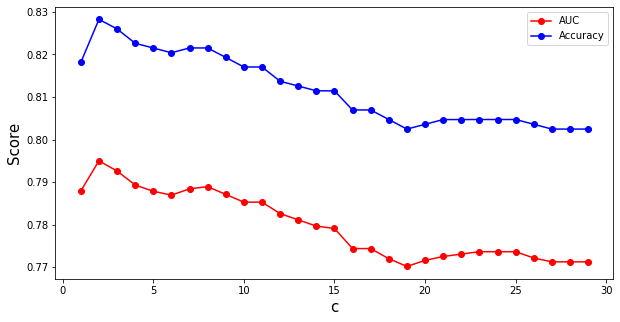

In [ ]:
from sklearn.svm import SVC
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
mauc = []
macc = []
vc = []
for c in range(1, 30):
    vauc = []
    vacc = []
    for train_index, test_index in cv.split(X, y):
        # select rows
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = SVC(C = c, gamma = 'auto')
        model.fit(x_train,y_train)
        y_pred = model.predict(x_test) 
        score = accuracy_score(y_pred, y_test)

        vauc.append(roc_auc_score(y_test, y_pred))
        vacc.append(accuracy_score(y_pred, y_test))
    macc.append(np.mean(vacc))
    mauc.append(np.mean(vauc))
    vc.append(c)
    #print('k:', k)
    #print('Average accuracy:', np.mean(vacc))
    #print('Average AUC:', np.mean(vauc))
best_c = np.argmax(mauc)+1
print('Melhor c:', best_c, ' AUC:',mauc[best_c-1])
plt.figure(figsize=(10,5))
plt.plot(vc, mauc, '-ro', label= 'AUC')
plt.plot(vc, macc, '-bo', label = 'Accuracy')
plt.xlabel('c', fontsize = 15)
plt.ylabel('Score', fontsize = 15)
plt.legend()
plt.show()

Realizando então a estratificação cruzada para encontrar o hiperparâmetro c que produz melhor resultado, podemos ver que este valor é igual a 2.

### Algumas métricas importantes para a classificação.

In [ ]:
from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, f1_score

model = SVC(C = 2, gamma = 'auto')
model.fit(x_train,y_train)
y_pred = model.predict(x_test) 
score = accuracy_score(y_pred, y_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average="macro"))
print('Precision:', precision_score(y_test, y_pred, average="macro"))
print('Recall:', recall_score(y_test, y_pred, average="macro"))

Accuracy: 0.7954545454545454
F1 score: 0.7685563997662186
Precision: 0.8072916666666667
Recall: 0.7570806100217865


Resultados muito parecidos com os utilizando KNN.


### Resultado Kaggle SVM

In [ ]:
model = SVC(C = 2, gamma = 'auto')
model.fit(x_train,y_train)
y_pred = model.predict(X_test) 
y_pred = np.array(y_pred, dtype = int)
prediction = pd.DataFrame()
prediction['PassengerId'] = PassengerId_test
prediction['Survived'] = y_pred

prediction.to_csv('Titanic-SVM-Douglas.csv', index = False)

Obtemos uma acurácia de **0.78708** no Kaggle.

# Árvores de decisão.

Melhor n: 6  AUC: 0.7985200746965453


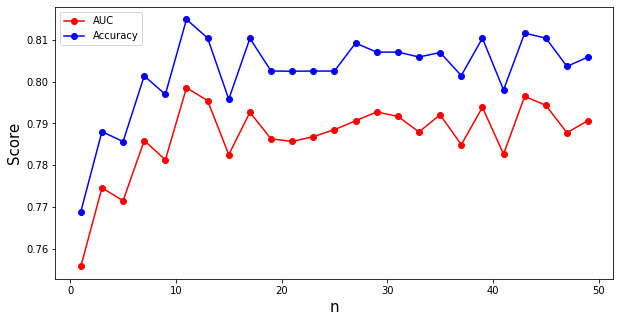

In [ ]:
from sklearn.ensemble import RandomForestClassifier

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
#cv = KFold(n_splits=10)
# enumerate the splits and summarize the distributions
mauc = []
macc = []
vn = []
for n in range(1, 50,2):
    vauc = []
    vacc = []
    for train_index, test_index in cv.split(X, y):
        # select rows
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = RandomForestClassifier(n_estimators=n)
        model.fit(x_train,y_train)
        y_pred = model.predict(x_test) 
        score = accuracy_score(y_pred, y_test)

        vauc.append(roc_auc_score(y_test, y_pred))
        vacc.append(accuracy_score(y_pred, y_test))
    macc.append(np.mean(vacc))
    mauc.append(np.mean(vauc))
    vn.append(n)
best_n = np.argmax(mauc)+1
print('Melhor n:', best_n, ' AUC:',mauc[best_n-1])
plt.figure(figsize=(10,5))
plt.plot(vn, mauc, '-ro', label= 'AUC')
plt.plot(vn, macc, '-bo', label = 'Accuracy')
plt.xlabel('n', fontsize = 15)
plt.ylabel('Score', fontsize = 15)
plt.legend()
plt.show()

Realizando então a estratificação cruzada para encontrar o hiperparâmetro n (número de árvores) que produz melhor resultado, podemos ver que este valor é igual a 6.

# Regressão Logística

In [ ]:
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

In [ ]:
#Treinamento do modelo realizando validação cruzada estratificada.
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
vauc = []
vacc = []
for train_index, test_index in cv.split(X, y):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter = 1000)
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test) 
    score = accuracy_score(y_pred, y_test)
    vacc.append(score)
    auc = roc_auc_score(y_test, y_pred)
    vauc.append(auc)
print('Acuracia media:', np.mean(vacc),'AUC medio:',np.mean(vauc))

Acuracia media: 0.7945882987175122 AUC medio: 0.7770189287836347


### Resultado Kaggle Regressão Logística

In [ ]:
model = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter = 1000)
model.fit(x_train,y_train)
y_pred = model.predict(X_test) 
y_pred = np.array(y_pred, dtype = int)
prediction = pd.DataFrame()
prediction['PassengerId'] = PassengerId_test
prediction['Survived'] = y_pred
prediction.to_csv('Titanic-LOGIT-Douglas.csv', index = False)

Obtemos uma acurácia de **0.77272** no Kaggle.

# Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB

## Naive Bayes Gaussiano

In [ ]:
#Treinamento do modelo realizando validação cruzada estratificada.
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
vauc = []
vacc = []
for train_index, test_index in cv.split(X, y):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = GaussianNB()
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test) 
    score = accuracy_score(y_pred, y_test)
    vacc.append(score)
    auc = roc_auc_score(y_test, y_pred)
    vauc.append(auc)
print('Acuracia media:', np.mean(vacc),'AUC medio:',np.mean(vauc))

Acuracia media: 0.7889331517421405 AUC medio: 0.776906601024248


### Resultado Kaggle Naive Bayes Gaussiano

In [ ]:
model = GaussianNB()
model.fit(x_train,y_train)
y_pred = model.predict(X_test) 
y_pred = np.array(y_pred, dtype = int)
prediction = pd.DataFrame()
prediction['PassengerId'] = PassengerId_test
prediction['Survived'] = y_pred
prediction.to_csv('Titanic-NBG-Douglas.csv', index = False)

Obtemos uma acurácia de **0.75119** no Kaggle.

## Naive Bayes Bernoulli

In [ ]:
#Treinamento do modelo realizando validação cruzada estratificada.
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
vauc = []
vacc = []
for train_index, test_index in cv.split(X, y):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = BernoulliNB()
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test) 
    score = accuracy_score(y_pred, y_test)
    vacc.append(score)
    auc = roc_auc_score(y_test, y_pred)
    vauc.append(auc)
print('Acuracia media:', np.mean(vacc),'AUC medio:',np.mean(vauc))

Acuracia media: 0.7811434570423333 AUC medio: 0.7689425062954475


### Resultado Kaggle Naive Bayes Bernoulli

In [ ]:
model = BernoulliNB()
model.fit(x_train,y_train)
y_pred = model.predict(X_test) 
y_pred = np.array(y_pred, dtype = int)
prediction = pd.DataFrame()
prediction['PassengerId'] = PassengerId_test
prediction['Survived'] = y_pred
prediction.to_csv('Titanic-NBB-Douglas.csv', index = False)

Obtemos uma acurácia de **0.75837** no Kaggle.

# Conclusões

Como podemos perceber, dentre todos os classificadores que utilizamos, o que obteve uma maior pontuação de acordo com o Kaggle foi o SVM, portanto, iremos utilizar novamente um GridSearch nele mas agora testanto outros parâmetros

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm
parameters = {'kernel':('linear', 'rbf'), 'C':[1,2,5,10,20,30, 50], 'gamma':['auto']}
svc = svm.SVC()
model = GridSearchCV(svc, parameters, cv = 5)
model.fit(X,y)
print('Best parameters:', model.best_params_)

print("Grid scores on development set:")
print()
means = model.cv_results_['mean_test_score']
stds = model.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, model.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))
print()

Best parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Grid scores on development set:

0.788 (+/-0.040) for {'C': 1, 'gamma': 'auto', 'kernel': 'linear'}
0.826 (+/-0.040) for {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
0.788 (+/-0.040) for {'C': 2, 'gamma': 'auto', 'kernel': 'linear'}
0.824 (+/-0.062) for {'C': 2, 'gamma': 'auto', 'kernel': 'rbf'}
0.788 (+/-0.040) for {'C': 5, 'gamma': 'auto', 'kernel': 'linear'}
0.819 (+/-0.050) for {'C': 5, 'gamma': 'auto', 'kernel': 'rbf'}
0.788 (+/-0.040) for {'C': 10, 'gamma': 'auto', 'kernel': 'linear'}
0.815 (+/-0.054) for {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
0.788 (+/-0.040) for {'C': 20, 'gamma': 'auto', 'kernel': 'linear'}
0.810 (+/-0.051) for {'C': 20, 'gamma': 'auto', 'kernel': 'rbf'}
0.788 (+/-0.040) for {'C': 30, 'gamma': 'auto', 'kernel': 'linear'}
0.804 (+/-0.058) for {'C': 30, 'gamma': 'auto', 'kernel': 'rbf'}
0.788 (+/-0.040) for {'C': 50, 'gamma': 'auto', 'kernel': 'linear'}
0.802 (+/-0.053) for {'C': 50, 'gamma': 'auto',

In [ ]:
print(model)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1, 2, 5, 10, 20, 30, 50], 'gamma': ['auto'],
                         'kernel': ('linear', 'rbf')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)


Podemos ver que utilizando a função GridSearch, o modelo que obteve melhor resultado foi o utilizando **c = 5** e **kernel = rbf**, então agora vamos submeter novamente no Kaggle com esse ajuste nos parâmetros para ver se conseguimos melhorar a classificação.

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.array(y_pred, dtype = int)
prediction = pd.DataFrame()
prediction['PassengerId'] = PassengerId_test
prediction['Survived'] = y_pred
prediction.to_csv('Titanic-SVMfinal- Douglas.csv', index = False)

Obtemos uma acurácia de **0.78968** no Kaggle. Que é um pouco maior que o resultado obtido quando utilizamoso SVM com **c = 2**

Finalmente, podemos levantar algumas dicussões sobre os resultados obtidos. Como os resultados não foram tão distantes, essas observações talvez não sejam reais em relação aos dados, mas mesmo assim achamos interessante levantar essas questões.

Podemos ver por exemplo, em relação ao Naive Bayes, o resultado do Naive Bayes de Benoulli se saiu um pouco melhor que o Gaussiano, achamos que isso pode ter sido ocorrido devido ao número de variáveis explicativas binárias (0 ou 1) tenha aumentado devido a realização do One Hot encoding, e até por consequência disso, um modelo Gaussiano nesses dados não foi a melhor opção, pelo menos em relação a este método. Também é legal ser levantado que como o resultado do Naive Bayes não se manteve tão abaixo dos outros, podemo dizer que a assumição de independência entre as features não foi algo que impactou negativamente os resultados.

Em relação ao KNN, o número de vizinhos escolhido pelo GridSearch (16), por ser um número um pouco alto, temos indícios de que as obsevações das classes estão sobrepostas. Também podemos observar que o gráfico do AUC em relação ao hiperparâmetro se manteve "constante" ao longo do aumento do número de vizinhos, o que corrobora com a primeira observação da sobreposição das classes.

Também pode-se dizer que como o resultado da regressão logística deu melhor que do KNN, temos indícios de que a região de separação das classes em n dimensões é linear.